In [1]:
import tensorflow as tf
from sklearn import preprocessing
import numpy as np
import random
import matplotlib.pyplot as plt
import sys
import os
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
# Add the parent directory to sys.path for module searching
sys.path.append(parent_dir)

import pandas as pd
from Pilsung import*
from Model.CNN import cnn_classifier
from utils.LoadData import load_CW_Source,load_CW_Target
from sklearn.utils import shuffle

d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\_distributor_init.py:30: UserWarning: loaded more than 1 DLL from .libs:
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.EL2C6PLE4ZYW3ECEVIV3OXXGRN2NRFM2.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.FB5AE2TYXYH2IJRDKGDGQ3XBKLKTF43H.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas.GK7GX5KEQ4F6UYO3P26ULGBQYHGQO7J4.gfortran-win_amd64.dll
d:\VirtualEnvironment\Anaconda3\envs\TF-krease\lib\site-packages\numpy\.libs\libopenblas64__v0.3.21-gcc_10_3_0.dll
  warnings.warn("loaded more than 1 DLL from .libs:"


In [ ]:
#Cache all possible S-boxes
def generateSbox(k1):
    key_total=np.zeros([32],dtype=np.int32)
    key_total[16]=k1
    gen_enc_perm(key_total,current_permutation_8,pboxes)
    sbox1=np.array(sboxes)
    return sbox1
Sbox_V=np.zeros([256,256])#  代表v=i,rk1=js时sbox^r(v)的值
Sbox_gen=np.zeros([256]) 
diffnum=np.zeros([256,256])
v_unique_num=np.zeros([256])# sbox^r(v)可取到的值

for k1 in range (256):
    Sbox_gen=np.array(generateSbox(k1))
    # print("sbox",Sbox_1[0][0][0])
    for v in range(256):
        #sbox^k(v)的所有可能值
        Sbox_V[k1][v]=Sbox_gen[0][0][v]

# attack function
def attack_RK0andRK1(reliable_predictions, p_v_box,key1,key2): 
    flag = 0  # Flag variable, initialized to 0
    guess_space0 = []  # List to store possible key space for rk0
    guess_space1 = []  # List to store possible key space for rk1

    for _ in range(1): 
        Key1_condidate = []  # List to store candidate keys for rk0
        Key2_condidate = []  # List to store candidate keys for rk1
        space1 = []  # List to store the number of candidates for rk0 at each step
        space2 = []  # List to store the number of candidates for rk1 at each step

        # Generate a list of 10 random integers in the range [0, 255]
        for index, P in enumerate(reliable_predictions):
            if index == 0:
                # Initialize temporary sets to store candidate keys, ensuring no duplicates
                temp_Key1 = set()
                temp_Key2 = set()
                for RK0 in range(256):
                    for RK1 in range(256):
                        V = Sbox_V[RK1][P ^ RK0]
                        if V == p_v_box[P]:  # Check if the output matches the expected value
                            temp_Key1.add(RK0)  # Add RK0 to the set of candidate keys for rk0
                            temp_Key2.add(RK1)  # Add RK1 to the set of candidate keys for rk1

                # Convert the sets to lists and update the candidate key lists
                Key1_condidate = list(temp_Key1)
                Key2_condidate = list(temp_Key2)
                space1.append(len(Key1_condidate))  # Record the number of candidates for rk0
                space2.append(len(Key2_condidate))  # Record the number of candidates for rk1
                
            else:
                temp_Key1 = set()
                temp_Key2 = set()
                
                # Iterate over the remaining candidate keys for rk0 and rk1
                for RK0_s in Key1_condidate:
                    for RK1_s in Key2_condidate:
   
                        V = Sbox_V[RK1_s][P ^ RK0_s]
                        if V == p_v_box[P]: 
                            temp_Key1.add(RK0_s)  # Add RK0_s to the set of candidate keys for rk0
                            temp_Key2.add(RK1_s)  # Add RK1_s to the set of candidate keys for rk1

                # Update the candidate lists with the filtered candidates
                Key1_condidate = list(temp_Key1)
                Key2_condidate = list(temp_Key2)
                space1.append(len(Key1_condidate))  # Record the number of candidates for rk0
                space2.append(len(Key2_condidate))  # Record the number of candidates for rk1

            # Early termination condition: if both rk0 and rk1 have only one candidate left
            if len(Key1_condidate) == 1 and len(Key2_condidate) == 1:
                guess_space0.append(space1)  # Store the key space for rk0
                guess_space1.append(space2)  # Store the key space for rk1
                
                
                # Check if the guessed keys match the expected correct values
                if Key1_condidate[0] == key1 and Key2_condidate[0] == key2:  
                    return 1
                else:  
                    return 0  
                break  
    return 0  

<b> Use model to obtain all the mapping $ \phi: p \mapsto v$ under different threshold

In [ ]:
import numpy as np
import pandas as pd
from sklearn import preprocessing

# Initialize variables
pk_v_box = np.zeros((256, 256))  # To store p^k to v mappings
p_v_box = np.zeros((256))        # To store p to v mappings
reliable_class = []
acc = []
p_v_prob=np.zeros([256])
SR_avg=[]


def get_pv_box(trace_num):
    """
    Updates p_v_box and p_v_prob based on the sum of traces for each plaintext.
    
    Parameters:
    - sum_by_plaintext: A pandas Series where the index is the plaintext and 
                         the values are the mean trace values for that plaintext.
    
    Returns:
    - p_v_box: List of predicted key values for each plaintext.
    - p_v_prob: List of the corresponding probabilities for each predicted key.
    """
     # Load training and attack data
    profiling_traces, _, _, _, _, _ = load_CW_Source(
            in_file=profiling_Data_path,
            sec=18000
        )
        # Load attack traces and associated data
    X_attack, label_V, p_attack = load_CW_Target(
            in_file=Target_Data_path,
        )
    # Shuffle datasets while maintaining correspondence
    X_attack, label_V, p_attack = shuffle(X_attack, label_V, p_attack)

    # Slice datasets to specified size
    X_attack_shuffle = X_attack[:trace_num]
    label_V_shuffle = label_V[:trace_num]
    p_attack_shuffle = p_attack[:trace_num]
        
            
    # Data preprocessing pipeline
    # 1. Standardization (zero-mean, unit-variance)
    scaler = preprocessing.StandardScaler()
    profiling_traces = scaler.fit_transform(profiling_traces)
    X_attack_shuffle = scaler.transform(X_attack_shuffle)
        
    # 2. Normalization to [0,1] range
    scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
    profiling_traces = scaler.fit_transform(profiling_traces)
    X_attack_shuffle = scaler.transform(X_attack_shuffle)

    # Generate model predictions
    predictions = model.predict(X_attack_shuffle)

    # Store predictions and plaintexts in a DataFrame
    A = np.squeeze(predictions)  # Predictions
    B = np.squeeze(p_attack_shuffle)     # Plaintext
    df = pd.DataFrame({'pred': list(A), 'plaintext': list(B)})

    # Calculate sum for each plaintext
    sum_by_plaintext = df.groupby('plaintext')['pred'].mean()


    p_v_box = [-1] * 256  # Initialize p_v_box with -1
    p_v_prob = [-1] * 256  # Initialize p_v_prob with -1
    
    for j in range(256):
        if j in sum_by_plaintext:
            p_v_box[j] = np.argmax(sum_by_plaintext[j])
            p_v_prob[j] = np.max(sum_by_plaintext[j])
    
    return p_v_box, p_v_prob

In [ ]:
def evaluate_attack_success_rate(model,t_num_range, num_runs=100, confidence_threshold=0.7,key1=0,key2=0):
    """
    Evaluate the success rate of the attack over a range of t_num values.
    
    Parameters:
    - model: the model used for attack
    - t_num_range: A range or list of t_num values to test.
    - num_runs: The number of runs to perform for each t_num.
    - confidence_threshold: The confidence threshold for reliable predictions.
    
    Returns:
    - A list of average success rates for each t_num.
    """
    SR_avg = []  # List to store success rate for each t_num
    for t_num in t_num_range:
        success_num = 0  # Track successful attacks for each t_num
        
        for _ in range(num_runs):
            # get p_v_box and p_v_prob based on sums
            p_v_box, p_v_prob = get_pv_box(t_num)

            # Select reliable predictions based on confidence threshold
            reliable_predictions = [i for i in range(len(p_v_prob)) if p_v_prob[i] >= confidence_threshold]

            # Attack detection function
            flag = attack_RK0andRK1(reliable_predictions, p_v_box,key1,key2)

            # Update success count
            success_num += flag
        
        # Calculate and store the success rate for this t_num
        success_rate = success_num / num_runs
        SR_avg.append(success_rate)
        print(f"Success rate for t_num {t_num}: {success_rate}")
    
    return SR_avg

<b>Evaluation

In [ ]:
# Main parameter initialization
profiling_Data_path='./Dataset/rk1=0x35/'
Target_Data_path = './Dataset/rk1=0xce/'  # Path to target device traces
model_path = './Model/'  # Pre-trained model directory
model_name = 'Source_Model(RK1=0x35).h5'  # Model filename

X_attack, label_V, p_attack = load_CW_Target(
            in_file=Target_Data_path)
p_attack_to_label_total=[]
p_attack_to_label_total.append({p: np.unique(label_V[p_attack == p]) for p in range(256)})

In [ ]:
model = cnn_classifier(input_size=600)
model.load_weights(model_path + model_name)
t_num_range = range(200,4001, 400)

## successful rate
key1=0x74
key2=0xce

SR_rk1_0xce_total=[]
reliable_num_avg_total=[]
for threshold in [0.5,0.6,0.7,0.8,0.9]:
        print(f'"######threshold: {threshold}######')
        SR_avg = evaluate_attack_success_rate(model,t_num_range,40,threshold,key1,key2)
        SR_rk1_0xce_total.append(SR_avg)


"######threshold: 0.5######
Success rate for t_num 200: 0.675
Success rate for t_num 600: 0.85
Success rate for t_num 1000: 0.85
Success rate for t_num 1400: 0.95
Success rate for t_num 1800: 1.0
Success rate for t_num 2200: 0.975
Success rate for t_num 2600: 1.0
Success rate for t_num 3000: 1.0
Success rate for t_num 3400: 1.0
Success rate for t_num 3800: 1.0
"######threshold: 0.6######
Success rate for t_num 200: 0.8
Success rate for t_num 600: 0.925
Success rate for t_num 1000: 0.975
Success rate for t_num 1400: 0.925
Success rate for t_num 1800: 0.975
Success rate for t_num 2200: 1.0
Success rate for t_num 2600: 0.975
Success rate for t_num 3000: 1.0
Success rate for t_num 3400: 1.0
Success rate for t_num 3800: 1.0
"######threshold: 0.7######
Success rate for t_num 200: 0.775
Success rate for t_num 600: 0.95
Success rate for t_num 1000: 0.975
Success rate for t_num 1400: 0.975
Success rate for t_num 1800: 0.975
Success rate for t_num 2200: 1.0
Success rate for t_num 2600: 1.0
Succe

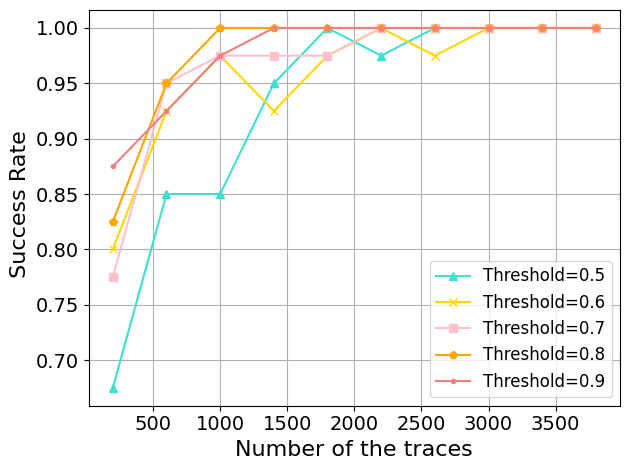

In [ ]:
x = np.arange(200, 4001, 400)
plt.plot(x, SR_rk1_0xce_total[0],color='turquoise', marker='^',label='Threshold=0.5')
plt.plot(x, SR_rk1_0xce_total[1],color='gold',marker='x',label='Threshold=0.6')
plt.plot(x, SR_rk1_0xce_total[2],color='pink',marker='s',label='Threshold=0.7')
plt.plot(x, SR_rk1_0xce_total[3],color='orange',marker='p',label='Threshold=0.8')
plt.plot(x, SR_rk1_0xce_total[4],color='lightcoral',marker='.',label='Threshold=0.9')


plt.grid(True) 

plt.xlabel('Number of the traces', fontsize=16)
plt.ylabel(' Success Rate', fontsize=16)
plt.legend(fontsize=12)
plt.tick_params(labelsize=14)
plt.tight_layout()
plt.savefig('Pilsung_SR.pdf')
plt.show()